In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if device == "cuda" else torch.float32

In [2]:
torch.manual_seed(32)
guidance_scale = 7.5
batch_size = 1

In [3]:
# pipe = StableDiffusionPipeline.from_pretrained(
#     "CompVis/stable-diffusion-v1-4",
#     dtype=torch_dtype,
# )
# pipe = pipe.to(device)
# pipe.enable_attention_slicing() 
# pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

In [4]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler


# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16)

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16)


scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [5]:
scheduler.set_timesteps(100)

In [6]:
prompt = "a photograph of an astronaut riding a horse"
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")

In [7]:
text_encoder = text_encoder.to(device)
pure_text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [8]:
pure_text_embeddings.requires_grad_(True)
pure_text_embeddings.retain_grad()

In [9]:
pure_text_embeddings.requires_grad

True

In [10]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

text_embeddings = torch.cat([uncond_embeddings, pure_text_embeddings])
text_embeddings = text_embeddings.to(torch.float16)

In [11]:
# with torch.no_grad():
with torch.enable_grad():
    latents = torch.randn((1, unet.in_channels, 64, 64), device=device)  # typical latent size
    latents = latents.to(torch_dtype) * scheduler.init_noise_sigma  # match scheduler expectations

/tmp/ipykernel_38594/1149839759.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 64, 64), device=device)  # typical latent size


In [12]:
x = latents

In [13]:
text_embeddings.dtype

torch.float16

In [14]:
import torch.utils.checkpoint as cp

unet = unet.to(device)
def unet_forward(model_input, t, text_embeds):
    return unet(model_input, t, encoder_hidden_states=text_embeds).sample


for i, t in enumerate(scheduler.timesteps):
    model_input = scheduler.scale_model_input(x, t)
    model_input = torch.cat([model_input] * 2)
    print(i, end = " ")
    # dummy = torch.tensor(0.0, requires_grad=True, device=model_input.device)
    # Apply checkpointing
    noise_pred = cp.checkpoint(unet_forward, model_input, t, text_embeddings)

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    # noise_pred = unet_forward(model_input, t, text_embeddings)

    scheduler_output = scheduler.step(noise_pred, t, x)
    x = scheduler_output.prev_sample

0 

/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [15]:
vae = vae.to(device)
with torch.enable_grad():
    image = vae.decode(x / 0.18215)
    image = image.sample

In [16]:
# write masking logic here
image.shape

torch.Size([1, 3, 512, 512])

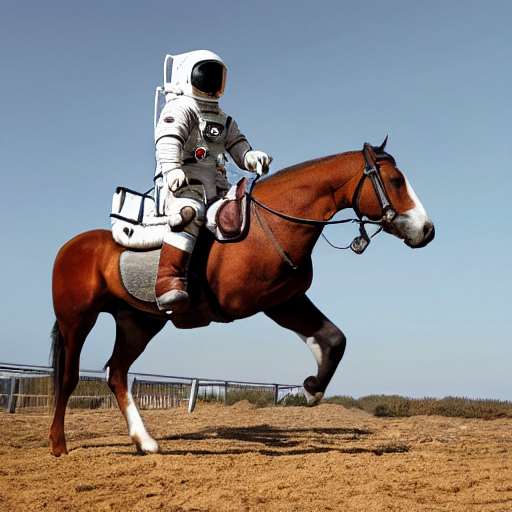

In [17]:
from torchvision.transforms import ToPILImage

pil_img = (image / 2 + 0.5).clamp(0, 1)
pil_img = pil_img.detach().cpu()
pil_img = ToPILImage()(pil_img[0]) 
pil_img

In [18]:
# masking logic
N, C, H, W = image.shape
center = (120, 300)
radius = 100
Y, X = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
dist = (X - center[1])**2 + (Y - center[0])**2
mask_2d = (dist <= radius**2).float()
mask = mask_2d.unsqueeze(0).unsqueeze(0).expand(N, C, H, W).to(device)

In [19]:
# mask_np = mask[0, 0].detach().cpu().numpy()
# masked_area = np.zeros((*mask_np.shape, 4))
# masked_area[mask_np == 1] = [0.6, 1.0, 0.6, 0.4]
# masked_area[mask_np == 0] = [0.0, 0.0, 0.0, 0.5]
# plt.imshow(img_np, cmap='gray')
# plt.imshow(masked_area)
# plt.axis('off')
# plt.show()

In [20]:
# MEAN is problematic, since the gradients are too small and with fp16 they are rounded down to 0
image_mean = (image * mask).sum()
image_mean.backward()

In [22]:
specials = {
    "bos_token": tokenizer.bos_token,
    "eos_token": tokenizer.eos_token,
    "pad_token": tokenizer.pad_token,
    "unk_token": tokenizer.unk_token,
    "additional_special_tokens": tokenizer.additional_special_tokens,
}

special_token_ids = set()

# Add basic special tokens
for attr in ["bos_token", "eos_token", "pad_token", "unk_token"]:
    token = getattr(tokenizer, attr, None)
    if token is not None:
        token_id = tokenizer.convert_tokens_to_ids(token)
        special_token_ids.add(token_id)

# Add additional special tokens (if any)
for token in tokenizer.additional_special_tokens:
    token_id = tokenizer.convert_tokens_to_ids(token)
    special_token_ids.add(token_id)

special_ids_tensor = torch.tensor(list(special_token_ids), device="cpu")
token_mask = ~torch.isin(text_input.input_ids[0], special_ids_tensor)
importance = (pure_text_embeddings.grad[0, token_mask] * pure_text_embeddings[0, token_mask]).norm(dim=-1)
final_importance = importance
if importance.norm() > 0:
    final_importance /= importance.norm()
if final_importance.sum() > 0:
    final_importance /= final_importance.sum()
token_ids = text_input.input_ids[0, token_mask]
for i, token_id in enumerate(token_ids):
    imp = final_importance[i]
    word = tokenizer.decode(token_id)
    print(f"Token: {word}, importance: {imp}")

Token: a, importance: 0.01291781198233366
Token: photograph, importance: 0.060542963445186615
Token: of, importance: 0.10016613453626633
Token: an, importance: 0.048634178936481476
Token: astronaut, importance: 0.28969258069992065
Token: riding, importance: 0.09714760631322861
Token: a, importance: 0.0428539477288723
Token: horse, importance: 0.3480447828769684


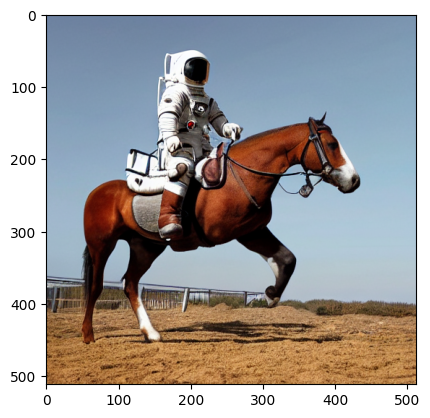

In [23]:
import numpy as np
img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32) # Squeeze if you want to remove the channel dimension
img_np = (img_np / 2 + 0.5)
img_np = np.clip(img_np, 0, 1)
import matplotlib.pyplot as plt
# Plot using matplotlib
plt.imshow(img_np, cmap='gray')

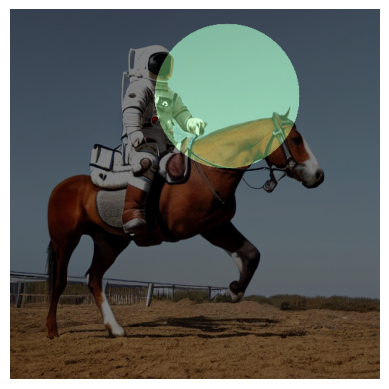

In [24]:
mask_np = mask[0, 0].detach().cpu().numpy()
masked_area = np.zeros((*mask_np.shape, 4))
masked_area[mask_np == 1] = [0.6, 1.0, 0.6, 0.4]
masked_area[mask_np == 0] = [0.0, 0.0, 0.0, 0.5]
plt.imshow(img_np, cmap='gray')
plt.imshow(masked_area)
plt.axis('off')
plt.show()

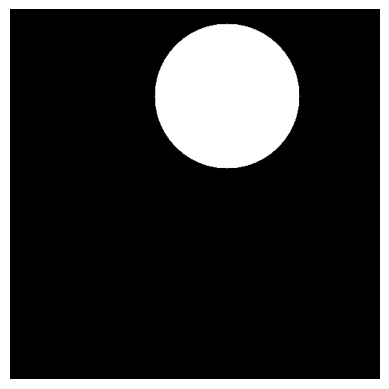

In [25]:
import numpy as np
mask_np = mask_2d.numpy()
plt.imshow(mask_np, cmap = 'gray')
plt.axis('off')
plt.savefig('masked_image.png', bbox_inches = 'tight', pad_inches = 0)

In [26]:
from PIL import Image

In [27]:
mask_rgb = np.stack([mask_np * 255]*3, axis=-1) 

In [28]:
Image.fromarray(mask_rgb.astype(np.uint8)).save("masked_image.png")

In [29]:
(mask_rgb == 256).sum()

np.int64(0)